# BetaDistribution NaiveBayes

In [1]:
import pandas as pd

X = pd.read_csv('features_set.csv')
y = pd.read_csv('classes_set.csv')

In [2]:
y = y.drop(columns=['Unnamed: 0'])
X = X.drop(columns=['Unnamed: 0'])
y = y.astype(int)
X = X/255.

Splitting training e tesing set

In [3]:
#attenzione, ho preso pochi varoli
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42, shuffle=True)

Implementation code:

In [8]:
import pandas as pd
from sklearn.base import BaseEstimator
from scipy.stats import beta
import numpy as np
import math

class BetaDistribution_NaiveBayes(BaseEstimator):
    
    def __init__(self) -> None:
        super().__init__()
        
    def fit(self,train_X:pd.DataFrame,train_y:pd.DataFrame):

        self.train_X=train_X
        self.train_y=train_y        
        
        self.classes = sorted(list(self.train_y['class'].unique())) #classes to be predict
        self.features = list(self.train_X.columns) #features

        self.__param_estimation()
        return self
        
       
    def __param_estimation(self):        
        
        self.prior = {} #prior probability of class
        self.mean = {}
        self.var = {}
        self.alpha = {}
        self.beta = {}
        
        
        for label in range(len(self.classes)):
            
            #Calculate P(Y=y) for all possible y
            self.prior[label] = (len(self.train_y[self.train_y['class']==label])/len(self.train_y))   
            
            #for each label, for each column in features
            X = self.train_X[self.train_y['class']==label]       
            
            self.mean[label] = np.mean(X, axis=0).to_numpy()
            self.var[label] = np.var(X, axis=0).to_numpy()
            
                       
            k=((self.mean[label] *(1-self.mean[label]) - self.var[label] + 0.1)/(self.var[label] + 0.1))
            self.alpha[label] = k*self.mean[label] 
            self.beta[label] = k*(1-self.mean[label])
            
            
            
    def predict(self,test_X:pd.DataFrame):
        
        epsilon=0.1
        
        # get feature names
        y_pred = []
        indexes = []
        
        # loop over every data sample
        for index, x in test_X.iterrows():
            # calculate likelihood
            pred=0
            pred_class=10
            for label in range(len(self.classes)):
                
                probs=beta.cdf(x + epsilon, self.alpha[label], self.beta[label])
                        -beta.cdf(x - epsilon, self.alpha[label], self.beta[label])
                
                #set nan values to one
                probs[np.isnan(probs)] = 1
               
                post_prob=self.prior[label]*np.prod(probs)

                if post_prob > pred:
                    pred=post_prob
                    pred_class=label
                    
            
            y_pred.append(pred_class)
            indexes.append(index)
            
        return pd.Series(data=y_pred,index=indexes) 

Fit:

In [9]:
betaD = BetaDistribution_NaiveBayes()
betaD.fit(X_train, y_train)

BetaDistribution_NaiveBayes()

Predict on Training Set:

In [10]:
import time
from sklearn.metrics import accuracy_score
# compute accuracy
start = time.time()
y_train_pred = betaD.predict(X_train)
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")
acc = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print ("on train Accuracy {:.3f}".format(acc) )

The time of execution of above program is : 532.320680141449 s
on train Accuracy 0.834


Predict on Testing Set:

In [11]:
import time
from sklearn.metrics import accuracy_score
# compute accuracy
start = time.time()
y_pred = betaD.predict(X_test)
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print ("on test Accuracy {:.3f}".format(acc) )

The time of execution of above program is : 95.73924708366394 s
on test Accuracy 0.835


Below we visualize some test samples and show their predicted digit value in the title.

In [12]:

from PIL import Image 
from matplotlib import cm 
 
def print_image(image): 
    myarray = np.reshape(image.to_numpy(), (28,28)) 
    im = Image.fromarray(np.uint8(cm.gist_earth(myarray)*255)) 
    width, height = im.size 
    new_width  = 300 
    new_height = new_width * height / width  
    new_height = 300 
    new_width  = new_height * width / height 
    img = im.resize((int(new_width), int(new_height)), Image.ANTIALIAS) 
    return img

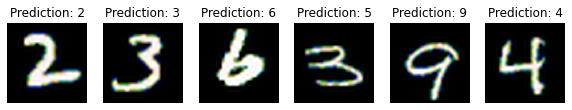

In [13]:
import matplotlib.pyplot as plt
n = 6 
_, axes = plt.subplots(nrows=1, ncols=n, figsize=(10, 3)) 
for ax, i, i in zip(axes, range(n), range(n)): 
    ax.set_axis_off() 
    image = print_image(X_test.iloc[i+6000]) 
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest") 
    ax.set_title(f"Prediction: {y_pred.to_numpy()[i+6000]}")

In [14]:
         
def missclassify(y_pred, y_test):
    indexes = []
    for index, row in y_test.iterrows(): 
        if(y_pred[index]!=row['class']):
            indexes.append(index)
    return indexes


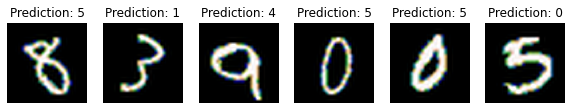

In [15]:
list = missclassify(y_pred, y_test)
n = 6 
_, axes = plt.subplots(nrows=1, ncols=n, figsize=(10, 3)) 
for ax, i, i in zip(axes, list, list): 
    ax.set_axis_off() 
    image = print_image(X.iloc[i]) 
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest") 
    ax.set_title(f"Prediction: {y_pred[i]}")


Confusion Matrix

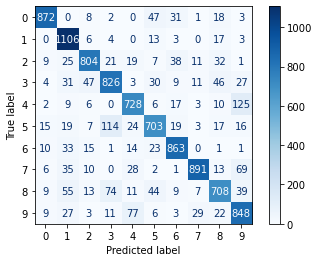

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
import numpy as np 
 
cm = confusion_matrix(y_test, y_pred, labels=sorted((y['class'].unique()))) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=sorted((y['class'].unique())), 
                             ) 
disp.plot(cmap=plt.cm.Blues) 
 
plt.show()